# CSE688: Practical and Application of Machine Learning - Spring 2021
## Assignment 3-1
### Authors

- B073040018 朱劭璿
- B072010029 陳居廷

#### Please use seq2seq model to build a autoencoder, which can generate the images from MNIST. Split the images into several small blocks and treat them as sequential data. Also, try to use different RNN layer (SimpleRNN, LSTM, GRU) and evaluate the quality of the generated images. Meanwhile, try to feed custom latent vectors into the decoder and observe the outputs.

## Create Dataset

Number of training samples: 60000
Number of testing  samples: 10000


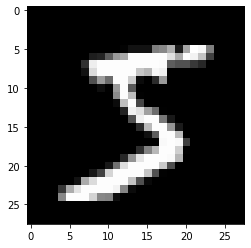

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import Image 

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print('Number of training samples:', train_images.shape[0])
print('Number of testing  samples:', test_images.shape[0])

ds_train = tf.data.Dataset.from_tensor_slices((train_images, train_images))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train_images.shape[0])
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.Dataset.from_tensor_slices((test_images, test_images))
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

plt.imshow(train_images[0], cmap='gray')

## Hyper Parameters

In [2]:
h_dim = 14
latent_dim = 10
num_epochs = 30

## Model Design

In [3]:
def encoder(
    h_dim,
    timesteps,
    data_dim,
    out_dim,
    rnn_layer=tf.keras.layers.SimpleRNN
):
    return tf.keras.Sequential([
        tf.keras.layers.Reshape((timesteps, data_dim), input_shape=(timesteps, data_dim, 1)),
        rnn_layer(h_dim, return_sequences=True),
        rnn_layer(h_dim, go_backwards=True),
        tf.keras.layers.Dense(out_dim)
    ])

test = encoder(h_dim, 28, 28, latent_dim)
test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28)            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 28, 14)            602       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 14)                406       
_________________________________________________________________
dense (Dense)                (None, 10)                150       
Total params: 1,158
Trainable params: 1,158
Non-trainable params: 0
_________________________________________________________________


In [4]:
def decoder(
    h_dim,
    timesteps,
    data_dim,
    out_dim,
    rnn_layer=tf.keras.layers.SimpleRNN
):
    return tf.keras.Sequential([
        tf.keras.layers.RepeatVector(timesteps, input_shape=(data_dim,)),
        rnn_layer(h_dim, return_sequences=True),
        rnn_layer(h_dim, return_sequences=True, go_backwards=True),
        tf.keras.layers.Dense(out_dim),
        tf.keras.layers.Reshape((timesteps, out_dim, 1))
    ])

test = decoder(h_dim, 28, latent_dim, 28)
test.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 28, 10)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 28, 14)            350       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 28, 14)            406       
_________________________________________________________________
dense_1 (Dense)              (None, 28, 28)            420       
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 1,176
Trainable params: 1,176
Non-trainable params: 0
_________________________________________________________________


## Training

In [5]:
def train(
    rnn_layer,
    save_weights=None,
    save_fig=None,
    load_weights=None,
    load_fig=None
):
    model = tf.keras.Sequential([
        encoder(h_dim, 28, 28, latent_dim, rnn_layer),
        decoder(h_dim, 28, latent_dim, 28, rnn_layer)
    ])
    
    if save_weights:
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='mse'
        )
        history = model.fit(
            ds_train,
            epochs=num_epochs,
            validation_data=ds_test
        )
        model.save_weights(save_weights)
        if save_fig:
            plt.clf()
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.savefig(save_fig)
    if load_weights:
        model.load_weights(load_weights)
    if load_fig:
        display(Image(filename=load_fig))
    return model

## Training Result
### Simple RNN

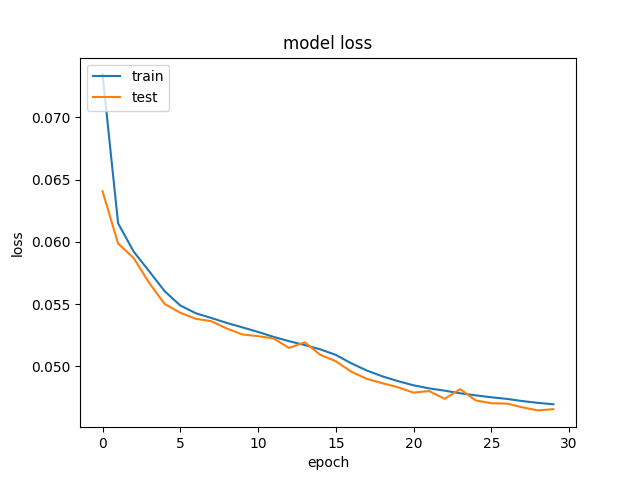

In [6]:
model_srnn = train(
    tf.keras.layers.SimpleRNN,
    load_weights="../assets/hw3-1/weights/SimpleRNN.h5",
    load_fig="../assets/hw3-1/images/SimpleRNN.png"
)

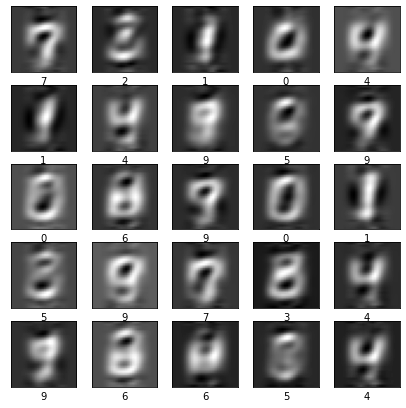

In [7]:
gen_images = model_srnn(test_images[:25])
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        gen_images[i],
        cmap='gray'
    )
    plt.xlabel(test_labels[i])

### LSTM

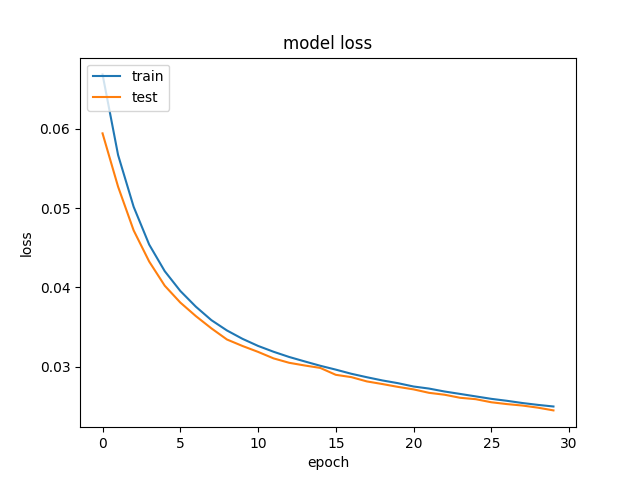

In [8]:
model_lstm = train(
    tf.keras.layers.LSTM,
    load_weights="../assets/hw3-1/weights/LSTM.h5",
    load_fig="../assets/hw3-1/images/LSTM.png"
)

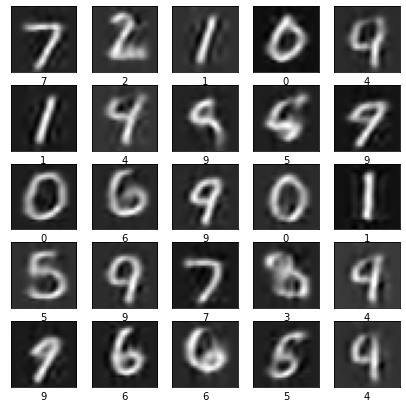

In [9]:
gen_images = model_lstm(test_images[:25])
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        gen_images[i],
        cmap='gray'
    )
    plt.xlabel(test_labels[i])

### GRU

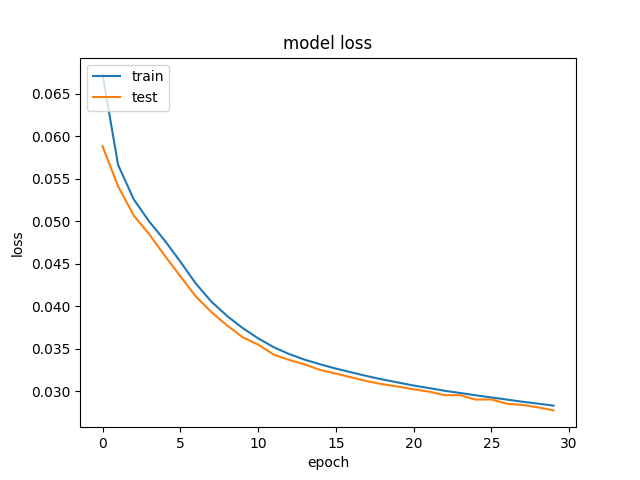

In [10]:
model_gru = train(
    tf.keras.layers.GRU,
    load_weights="../assets/hw3-1/weights/GRU.h5",
    load_fig="../assets/hw3-1/images/GRU.png"
)

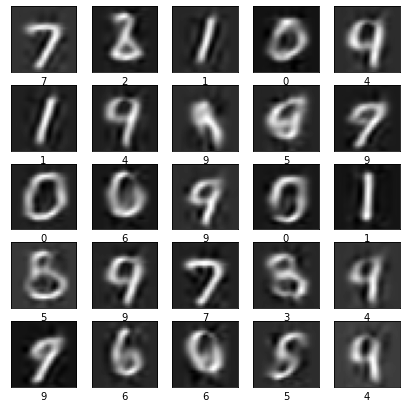

In [11]:
gen_images = model_gru(test_images[:25])
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        gen_images[i],
        cmap='gray'
    )
    plt.xlabel(test_labels[i])

## Plot Latent Space with t-SNE

In [12]:
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
import numpy as np
def plot_latent(enc, title):
    latent = enc(test_images)
    reduced = TSNE(n_components=2, n_jobs=-1).fit_transform(latent)
    plt.figure(figsize=(14, 10))
    plt.title(title)
    plt.scatter(reduced[:, 0], reduced[:, 1], c=test_labels)
    txts = []
    for i in range(10):
        xtext, ytext = np.median(reduced[test_labels == i, :], axis=0)
        txt = plt.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    plt.show()
    return latent.numpy()

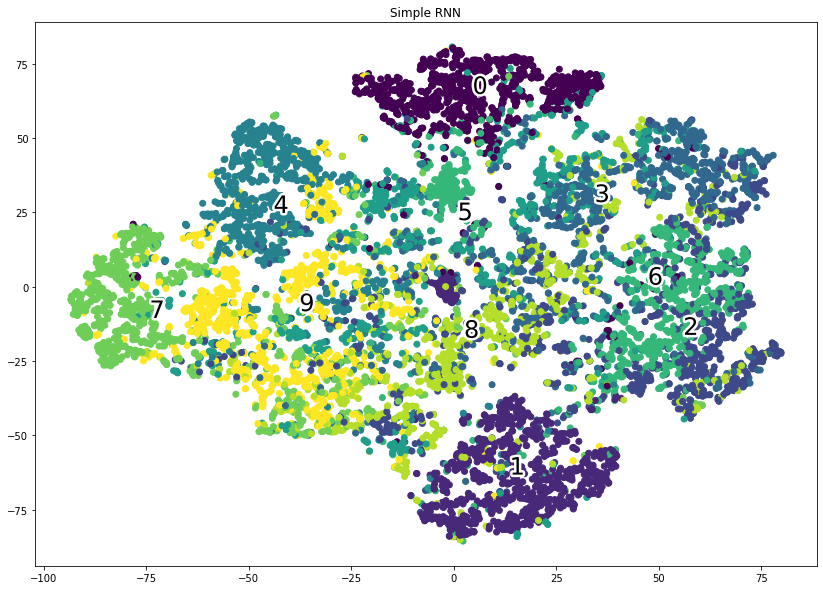

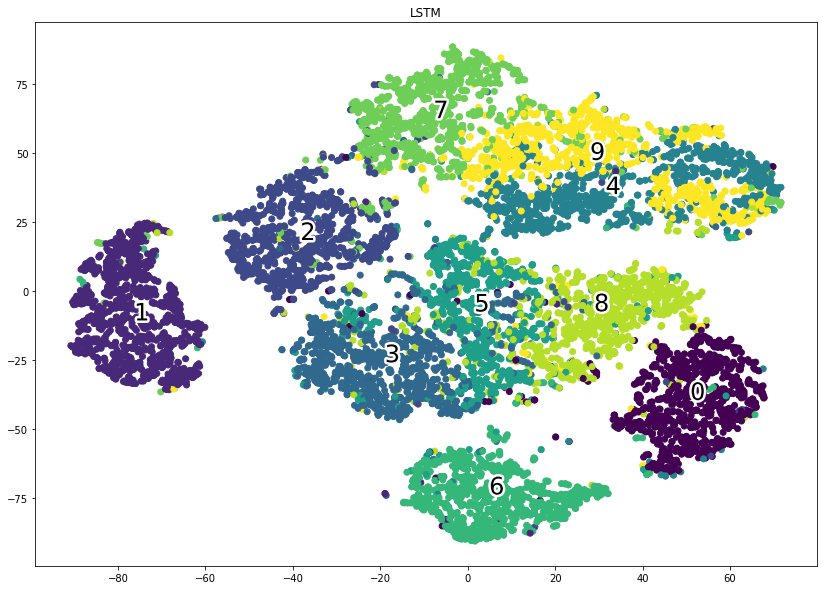

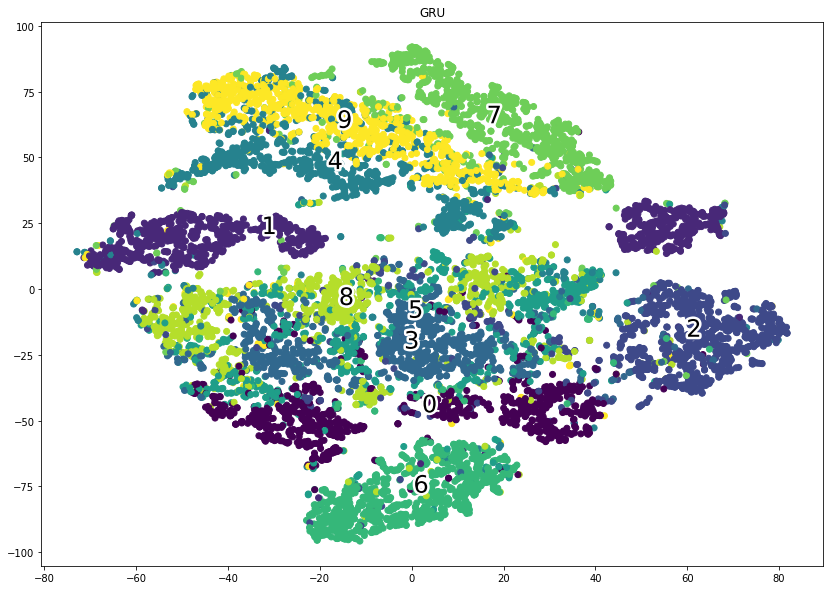

In [13]:
enc_srnn = model_srnn.get_layer(index=0)
enc_lstm = model_lstm.get_layer(index=0)
enc_gru = model_gru.get_layer(index=0)

latent_srnn = plot_latent(enc_srnn, 'Simple RNN')
latent_lstm = plot_latent(enc_lstm, 'LSTM')
latent_gru = plot_latent(enc_gru, 'GRU')

## Interpolation

In [ ]:
def interpolation_matrix(model, corners):
    num_samples = 10
    upper = np.linspace(corners[0], corners[1], num_samples)
    lower = np.linspace(corners[2], corners[3], num_samples)
    matrix = np.linspace(upper, lower, num_samples)
    matrix = matrix.reshape(num_samples**2, *corners[0].shape)
    gen_images = model(matrix)
    plt.figure(figsize=(10, 10))
    for i in range(num_samples**2):
        plt.subplot(num_samples, num_samples, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(
            gen_images[i],
            cmap='gray'
        )
            
dec_srnn = model_srnn.get_layer(index=1)
dec_lstm = model_lstm.get_layer(index=1)
dec_gru = model_gru.get_layer(index=1)

### Simple RNN

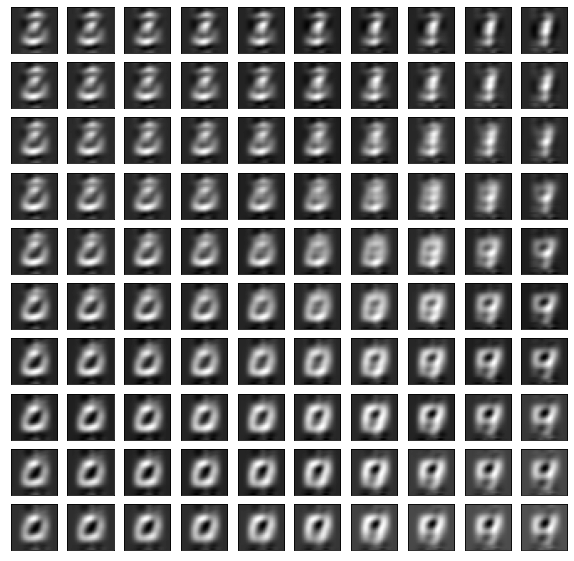

In [ ]:
interpolation_matrix(dec_srnn, latent_srnn[1:1+4])

### LSTM

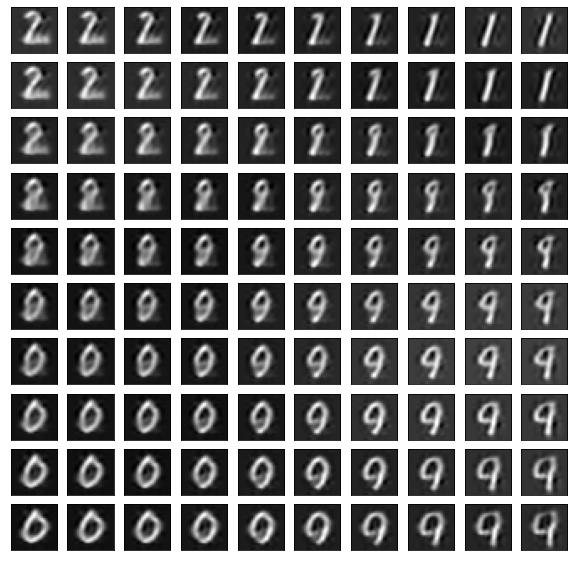

In [ ]:
interpolation_matrix(dec_lstm, latent_lstm[1:1+4])

### GRU

In [ ]:
interpolation_matrix(dec_gru, latent_gru[1:1+4])